## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Camera calibration using chessboard images

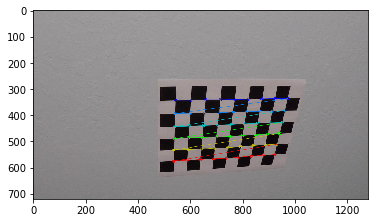

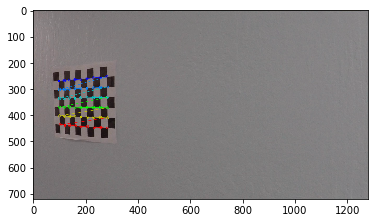

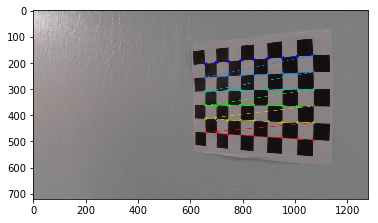

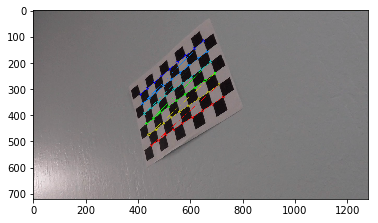

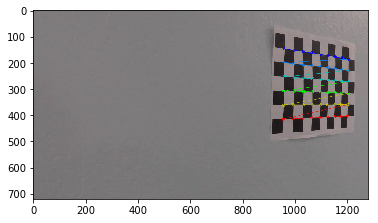

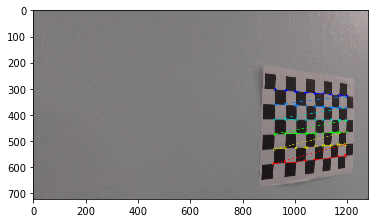

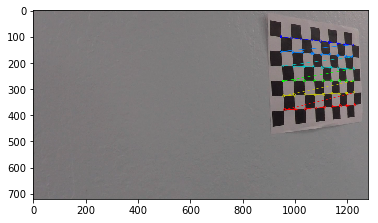

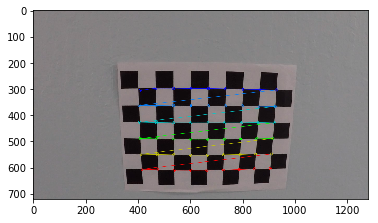

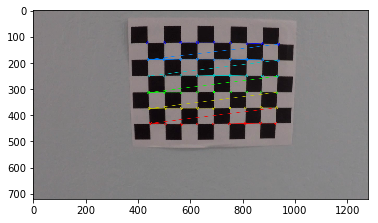

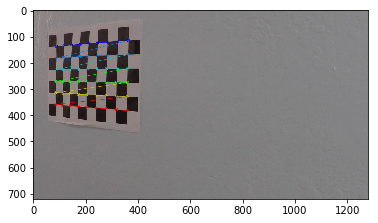

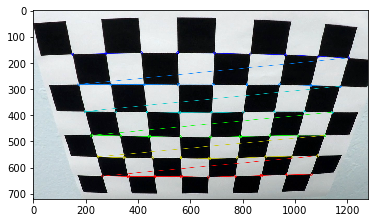

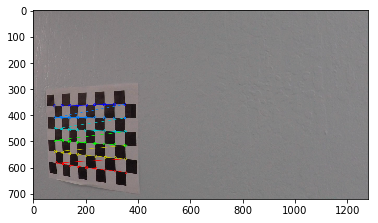

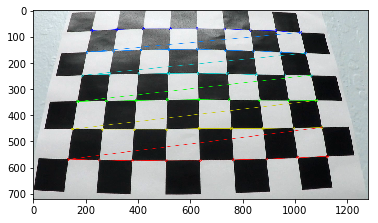

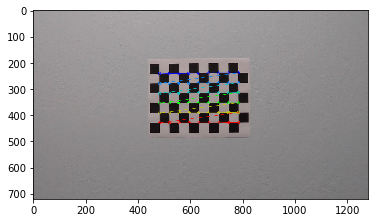

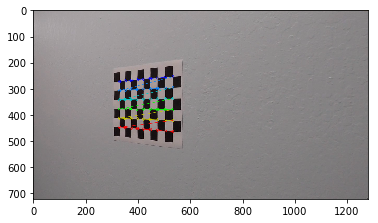

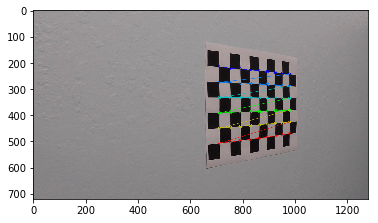

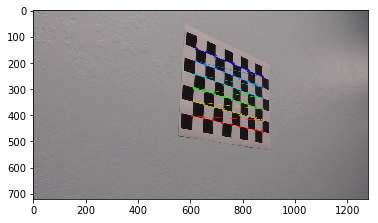

((54, 1, 2), (54, 3))
((17, 54, 1, 2), (17, 54, 3))


In [57]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

imgpoints = np.array(imgpoints, dtype=np.float32)
objpoints = np.array(objpoints, dtype=np.float32)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,(1280,720),None, None)
print(imgpoints[0].shape, objpoints[0].shape)
print(imgpoints.shape, objpoints.shape)
    

## Step 2: Undistorting images
### Check to see if images are being undistorted. 

(720, 1280, 3)


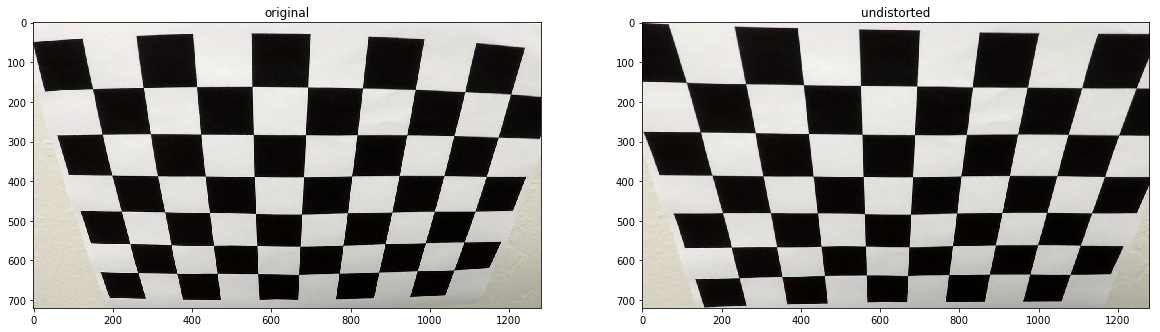

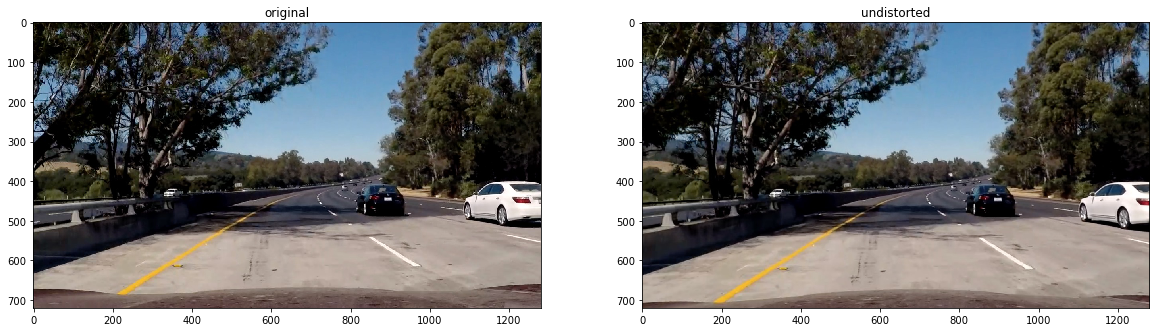

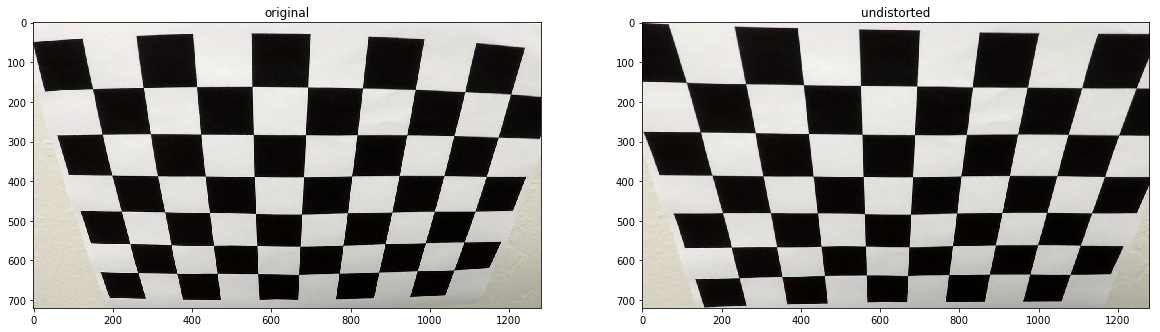

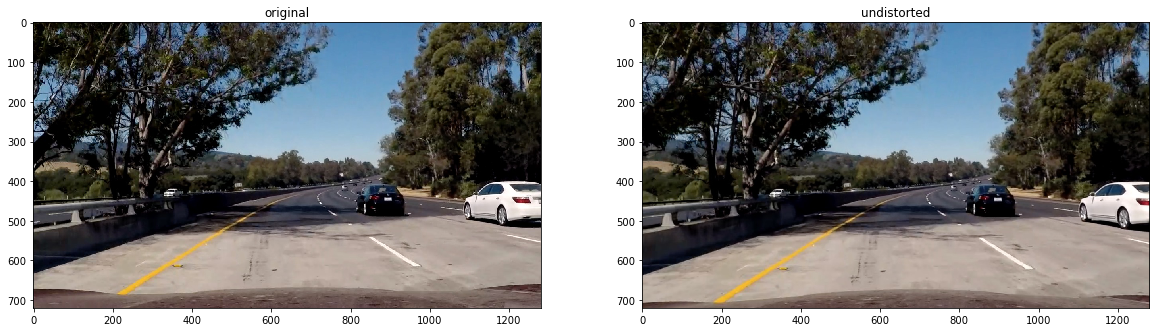

In [59]:
img = cv2.imread("../camera_cal/calibration2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
fig ,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title("original")
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title("undistorted")
ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))

img = cv2.imread("../test_images/test5.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
fig ,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title("original")
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title("undistorted")
ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
print(undist.shape)
plt.show()
        

## Step 3: Perform Thresholding
### Step 3.1: First extract the s-channel and threshold it

In [145]:

PLOT_IMGS = True
import matplotlib.image as mpimg
def chan_thresholds(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hchan = hls[:,:,0]
    lchan = hls[:,:,1]
    schan = hls[:,:,2]
    binary_s = np.zeros_like(schan)
    binary_s[(schan > 180) & (schan < 235)] = 1

    if PLOT_IMGS:
        f, (ax2) = plt.subplots(1,1,figsize=(15,10))
        ax2.set_title("color")
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
        ax1.set_title("h_channel")
        ax1.imshow(hchan, cmap="gray")
        ax2.set_title("l_channel")
        ax2.imshow(lchan, cmap="gray")
        ax3.set_title("s_channel")
        ax3.imshow(schan, cmap="gray")
        mpimg.imsave("h_channel_img", hchan, cmap="gray")
        mpimg.imsave("s_channel_img", schan, cmap="gray")
        binary_h = np.zeros_like(hchan)
        binary_h[(hchan < 50)] = 1

        mpimg.imsave("s_threshold_img", binary_s, cmap="gray")
        f, (ax2) = plt.subplots(1,1,figsize=(15,10))
        ax2.set_title("thresholded s-channel")
        ax2.imshow(binary_s, cmap="gray")
        plt.show()

    return binary_s

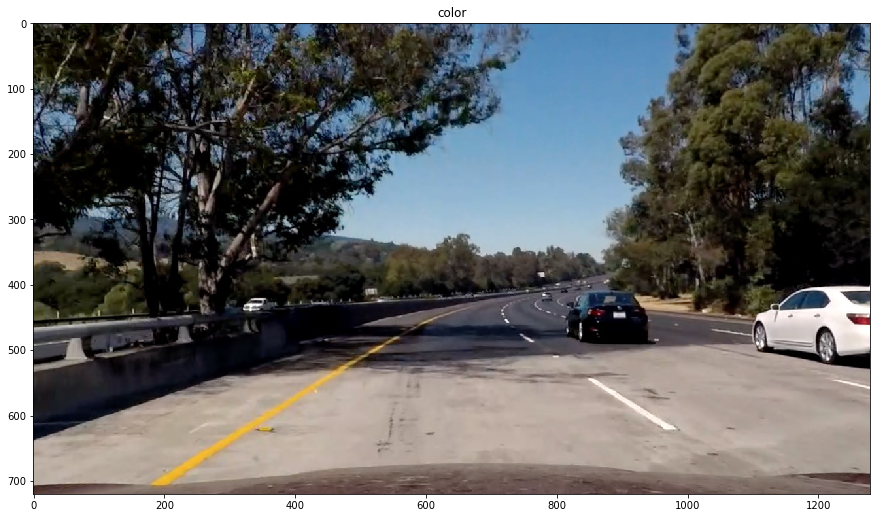

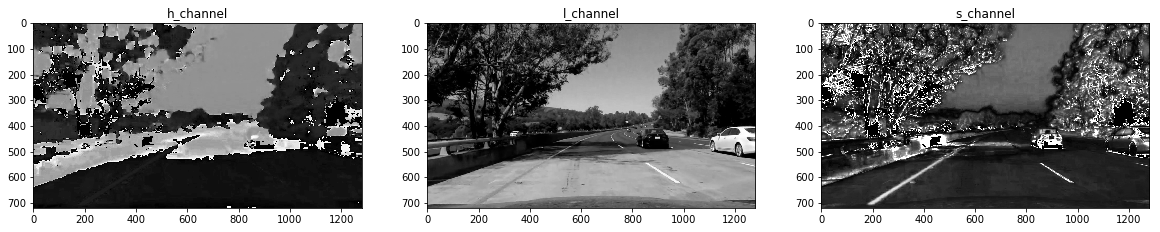

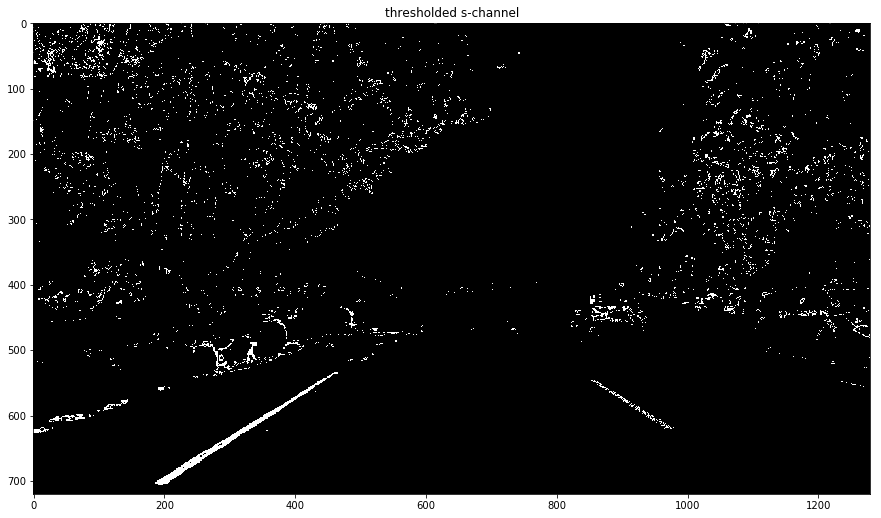

In [146]:
binary_s_chan = chan_thresholds(undist)

### Step 3.2: Apply Sobel operator to image and then threshold it

In [147]:
def calc_sobel(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    magnitude_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    scaled_sobel = np.uint8(magnitude_sobel*255/np.max(magnitude_sobel))
    magnitude_sobel_thresh = np.zeros_like(scaled_sobel, dtype=np.float32)
    magnitude_sobel_thresh[(scaled_sobel > 50)] = 1
    
    sobel_dir = np.arctan2(abs_sobely, abs_sobelx)
    sobel_dir_thresh = np.zeros_like(sobel_dir, dtype=np.float32)
    sobel_dir_thresh[(sobel_dir > 0.5) & (sobel_dir < 1.35)] = 1
    
    sobel_comb = np.zeros_like(gray, dtype=np.float32)
    sobel_comb[(sobel_dir_thresh == 1) & (magnitude_sobel_thresh == 1)] = 1
    
    if PLOT_IMGS:
        f, (ax1) = plt.subplots(1,1,figsize=(15,10))
        ax1.set_title("gray input")
        ax1.imshow(gray, cmap="gray")
        
        f, ax = plt.subplots(2,2,figsize=(20,10))
        scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        ax[0][0].imshow(scaled_sobel_x, cmap="gray")

        scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))
        ax[0][1].imshow(scaled_sobel_y, cmap="gray")    

        ax[1][0].imshow(magnitude_sobel_thresh, cmap="gray")   
        ax[1][1].imshow(sobel_dir_thresh, cmap="gray")
        mpimg.imsave("sobel_magnitude_scaled", scaled_sobel, cmap="gray")
        mpimg.imsave("sobel_dir", sobel_dir, cmap="gray")
        mpimg.imsave("sobel_combo", sobel_comb, cmap="gray")

        f, (ax1) = plt.subplots(1,1,figsize=(15,10))
        ax1.set_title("sobel")
        ax1.imshow(sobel_comb, cmap="gray")
        plt.show()
    return sobel_comb

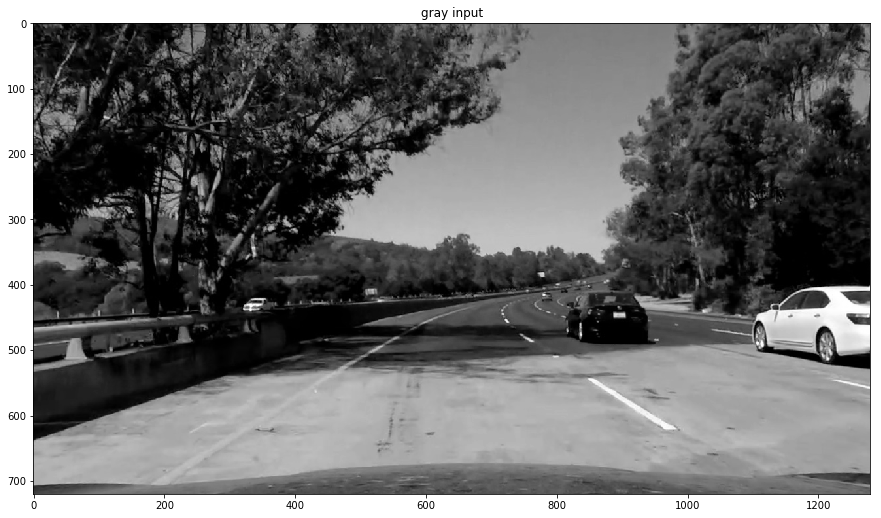

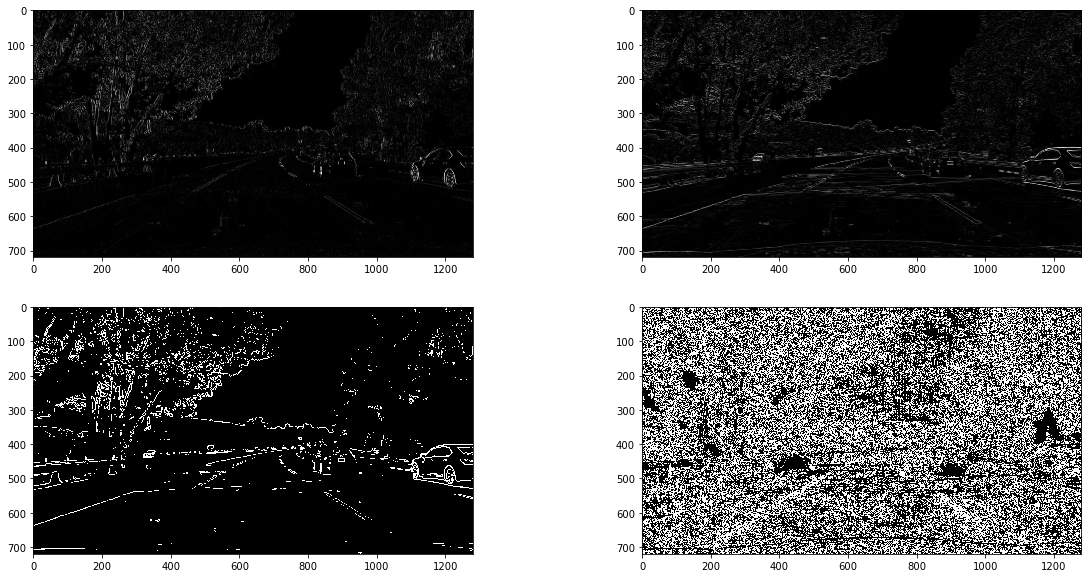

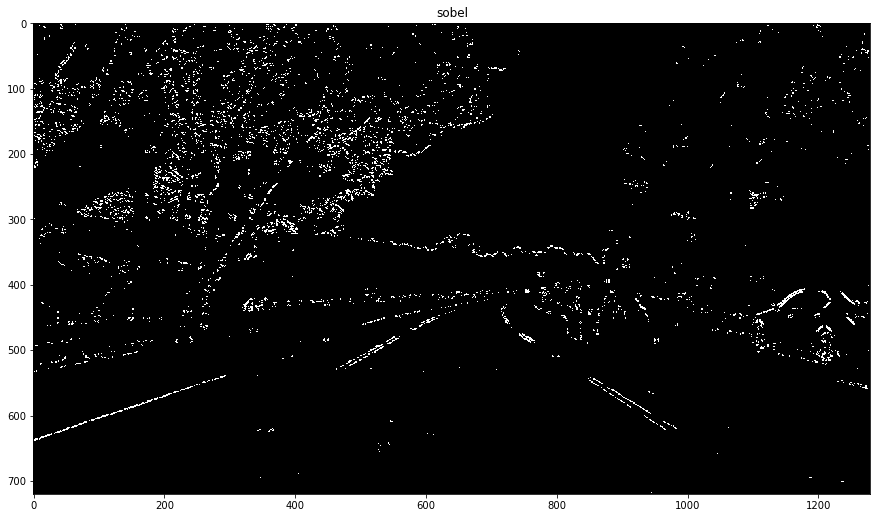

In [148]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)    
sobel_combo = calc_sobel(gray)

### Step 3.3: Combine color and sobel thresholded images

In [64]:
def combine_gradient(gray, sobel, s_channel):
    comb = np.zeros_like(gray)
    comb[(sobel == 1) | (s_channel == 1)] = 1
    return comb

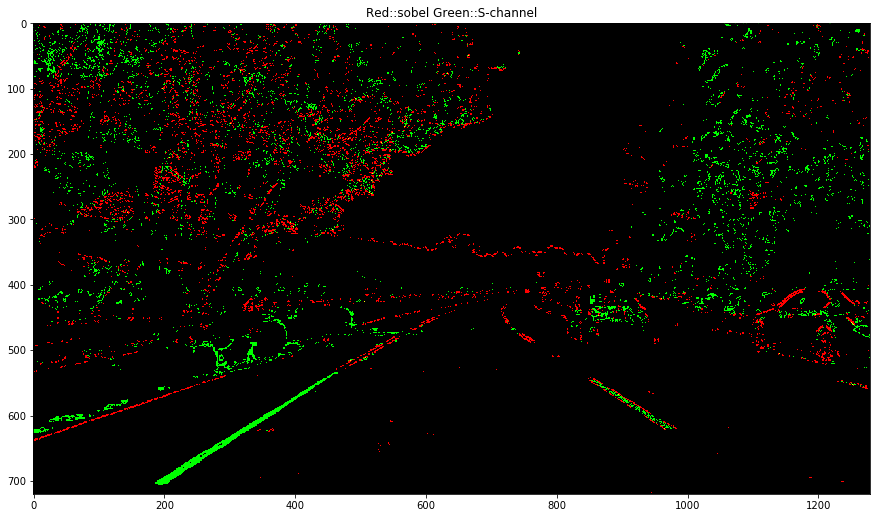

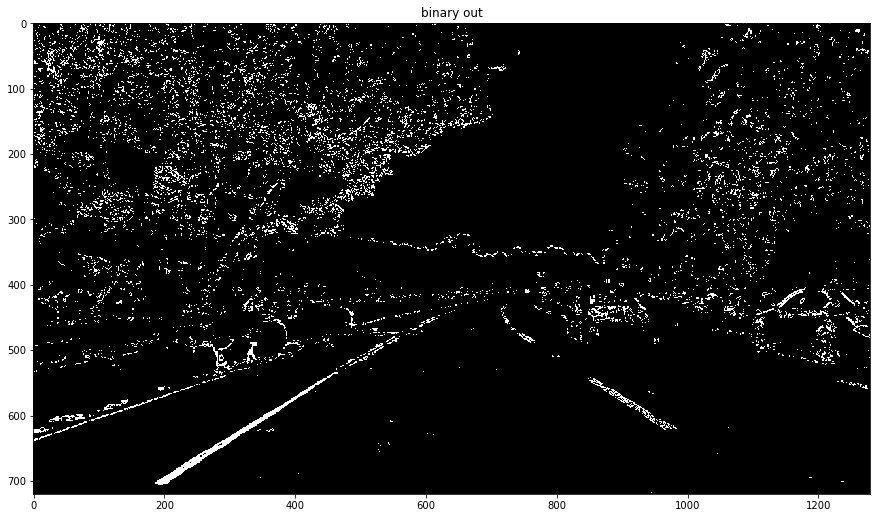

In [65]:
combined_img = combine_gradient(gray, sobel_combo, binary_s_chan)
_, ax1 = plt.subplots(1,1,figsize=(15,10))
_, ax2 = plt.subplots(1,1,figsize=(15,10))
color_stack = np.stack((sobel_combo, binary_s_chan, np.zeros_like(sobel_combo)), axis=2).astype(np.float32)
ax1.imshow(color_stack)
ax1.set_title("Red::sobel Green::S-channel")
ax2.imshow(combined_img, cmap="gray")
ax2.set_title("binary out")
mpimg.imsave("combined_gradient_img", combined_img, cmap="gray")
plt.show()

## Step 4: Apply perspective transform

In [66]:
def perspective_transform():
    src = np.float32([[325,650],[990,650],[420,580],[880,580]])
    dst = np.float32([[300,670],[1000,670],[300,600],[993,600]])

    img = cv2.getPerspectiveTransform(src, dst)
    img_inv = cv2.getPerspectiveTransform(dst, src)

    return img, img_inv

(1280, 720)


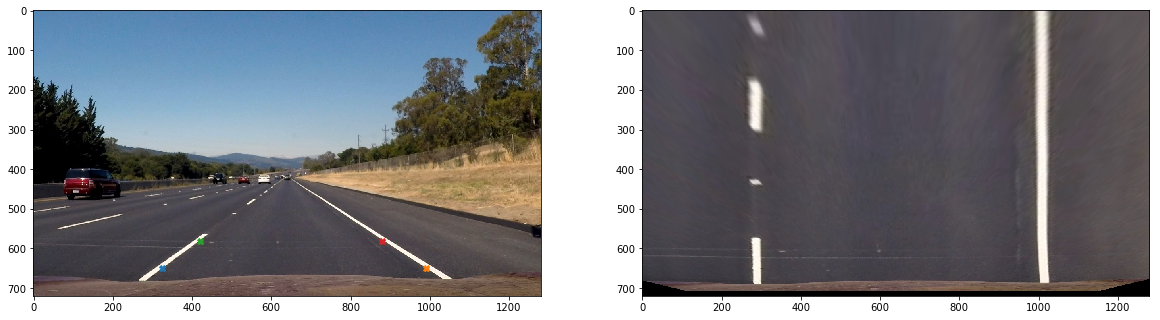

In [99]:
test_img = mpimg.imread("../test_images/straight_lines2.jpg")
width = test_img.shape[1]
height = test_img.shape[0]
persp, persp_inv = perspective_transform()
warped = cv2.warpPerspective(test_img, persp, (width,height), flags=cv2.INTER_LINEAR)
print(width, height)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(test_img)
ax1.plot(325,650,"X")
ax1.plot(990,650,"X")
ax1.plot(420,580,"X")
ax1.plot(880,580,"X")
ax2.imshow(warped)
plt.show()



In [149]:
def warp_perspective(img, persp):
    transformed = cv2.warpPerspective(img, persp, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    if PLOT_IMGS:
        _, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
        ax1.imshow(img, cmap="gray")
        ax2.imshow(transformed, cmap="gray")
        plt.show()
        
    return transformed


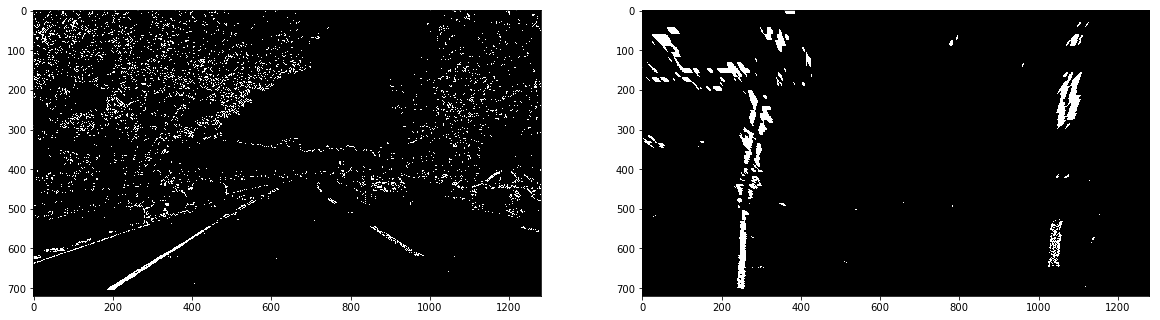

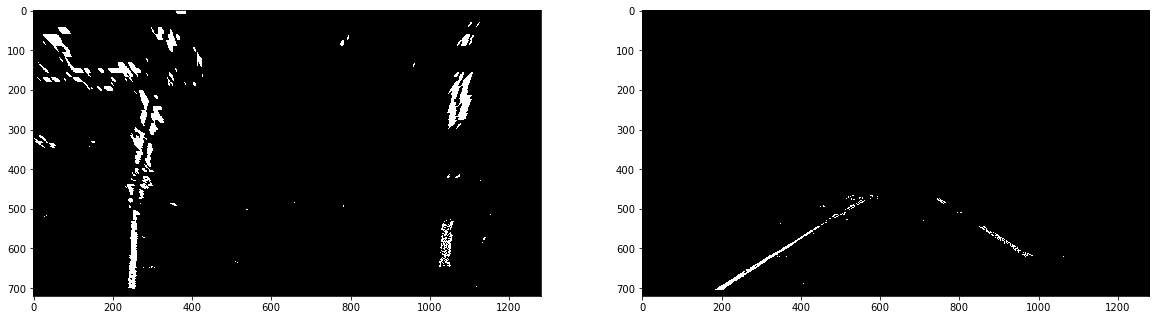

In [150]:
warped = warp_perspective(combined_img, persp)
_ = warp_perspective(warped, persp_inv)

## Step 5: Detect Lane Lines and curvature
### Step 5.1: Define a Line class for left and right lines for the respective lanes, as suggested by the lessons.

In [101]:
class Line():
    def __init__(self): 
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0.0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0.0  
        self.currfit_x = [] 
        self.currfit_y = []
        self.past_coeffs= [] #last 10 frames
        #average x values of the fitted line over the last n iterations
        self.bestx = 0.0  
        self.recent_xfitted = [] #last x values
       

### Step 5.2: Helper functions to draw rectangles and the curves 

In [140]:
#fit a 2nd order polynomial to go through the base points for lanes, one for each left and right lanes
# factor in smoothing
def fit_poly_line(img, detected_base, line, poly=2):
    yp = np.linspace(0, img.shape[0]-1, img.shape[0])
    fitted = np.polyfit(detected_base[:,0], detected_base[:,1], poly)
    l = len(line.past_coeffs)
    if l == 0:     
        line.past_coeffs = np.array([fitted])
        line.recent_xfitted = np.array([fitted])
        coeffs = fitted
        avg = np.average(line.past_coeffs, axis=0) #performing smoothing via averaging
        line.bestx = avg     
    elif line.past_coeffs.shape[0] < 5:
        line.past_coeffs = np.concatenate((line.past_coeffs, [fitted]), axis=0)
        line.recent_xfitted = np.concatenate((line.recent_xfitted, [fitted]), axis=0)
        coeffs = fitted
        avg = np.average(line.past_coeffs, axis=0)
        line.bestx = avg
    else:       
        sd_past = np.std(line.recent_xfitted, axis=0)
        mean_past= np.mean(line.recent_xfitted, axis=0)
        if np.any(np.abs(fitted-mean_past) > 1.3*sd_past): 
            coeffs = line.bestx
        else:
            coeffs = fitted*0.4 + line.bestx*0.6 #use past data to smooth 

        line.recent_xfitted = np.concatenate((line.recent_xfitted[-29:], [fitted]), axis=0)
        line.past_coeffs = np.concatenate((line.past_coeffs[-9:], [coeffs]), axis=0)
        line.bestx = np.average(line.past_coeffs, axis=0)     
    
    fit_left = np.poly1d(coeffs)
    xp = fit_left(yp)
    return coeffs, yp, xp

def draw_rec(img, cent, w=70, h=70):
    img[cent[0]-h//2-2:cent[0]-h//2 +2, cent[1]-w//2:cent[1]+w//2] = [1,0.5,0.5]
    img[cent[0]+h//2-2:cent[0]+h//2 +2, cent[1]-w//2:cent[1]+w//2] = [1,0.5,0.5]
    img[cent[0]-h//2:cent[0]+h//2, cent[1]-w//2 -2:cent[1]-w//2+2] = [1,0.5,0.5]
    img[cent[0]-h//2:cent[0]+h//2, cent[1]+w//2 -2:cent[1]+w//2+2] = [1,0.5,0.5]
    return

### Step 5.3: Find lanes using convolution. Also find the radius of cuvature when lanes are found

In [151]:
y_step = -20  #Can vary these params
x_step = 10
marginx = 80 # Tried diefferent values; this was suggested in the forums
k = 50 #size of filter

def find_lanes(img, left, right):
    left_lane = [] # left lane points
    right_lane = [] # right lane points
    f = np.ones((k,k))
    global frame  
    
    img_stripped = img[-600:,15:-15]
    
    if PLOT_IMGS:
        color_img = cv2.cvtColor(img_stripped.astype(np.float32), cv2.COLOR_GRAY2RGB)
        _, ax1 = plt.subplots(1,1, figsize=(15,10))
        _, ax2 = plt.subplots(1,1, figsize=(15,10))
        ax1.imshow(img_stripped, cmap="gray")
    
    for y in range(img_stripped.shape[0], 0, y_step):
        conv_left_max = 0
        conv_right_max = 0
        for x in range(0, img_stripped.shape[1], x_step):
            conv = np.sum(np.multiply(f[:(img_stripped[y-k:y,x:x+k].shape[0]),:(img_stripped[y-k:y,x:x+k].shape[1])], img_stripped[y-k:y,x:x+k]))        
            
            if conv < 200: #choose only points beyond a certain threshold; threshold was chosen by experimentation
                continue
                
            if x < img_stripped.shape[1]/2: #assuming the car is at the center of the lane
                if conv > conv_left_max: #choose the best point along x-axis
                    if len(left_lane) > 0 and (abs(left_lane[-1:][0][1] - (x+k/2)) > marginx):
                        continue
                    conv_left_max = conv
                    cord_left_max = [y-k//2,x+k//2]
            else:
                if conv > conv_right_max: #choose only the best point along x-axis 
                    if len(right_lane) > 0 and (abs(right_lane[-1:][0][1] -(x+k/2)) > marginx):
                        continue
                    conv_right_max = conv
                    cord_right_max = [y-k//2, x+k//2]
                    
         
        #  select the best point and append to the left/right lanes
        if conv_left_max > 0:
            left_lane.append(cord_left_max)
            if PLOT_IMGS:
                ax2.plot(cord_left_max[1], cord_left_max[0],"X")
                draw_rec(color_img, cord_left_max, 50, 50)
                     
        if conv_right_max > 0:
            right_lane.append(cord_right_max)
            if PLOT_IMGS:
                draw_rec(color_img, cord_right_max, 50, 50)
                ax2.plot(cord_right_max[1], cord_right_max[0],"X")
    
    # Calculate ROC if lanes exist; used the ROC code from lesson         
    if len(left_lane) > 0: 
        left_lane = np.array(left_lane)
        left_coeffs, yp, xp_left =  fit_poly_line(img, left_lane,left)
        fitcr = np.polyfit(yp*30/750, xp_left*3.7/750,2)
        left.radius_of_curvature = ((1 + (2*fitcr[0]*np.max(yp)*30/750.0 + fitcr[1])**2)**1.5)/np.absolute(2*fitcr[0])
        #print left.radius_of_curvature
        left.currfit_x = xp_left
        left.currfit_y = yp
        if PLOT_IMGS:
            ax2.plot(xp_left,yp,"b-",linewidth=5)
            ax2.text(350,50,'Left radius of curvature={:.2f}'.format(left.radius_of_curvature),color="white")
    else:
        print("ERROR: No left lane detected {}".format(frame))
    
    if len(right_lane) > 0:
        right_lane = np.array(right_lane)
        right_coeffs, yp, xp_right = fit_poly_line(img, right_lane,right)
        fitcr = np.polyfit(yp*30/750, xp_right*3.7/750,2)
        right.radius_of_curvature = ((1 + (2*fitcr[0]*np.max(yp)*30/750.0 + fitcr[1])**2)**1.5)/np.absolute(2*fitcr[0])
        #print right.radius_of_curvature
        right.currfit_x = xp_right   
        right.currfit_y = yp
        if PLOT_IMGS:
            ax2.plot(xp_right,yp,"b-",linewidth=5)
            ax2.text(350,100,'Right radius of curvature={:.2f}'.format(right.radius_of_curvature),color="white")
    else:
        print("ERROR: No right lane detected {}".format(frame))  
    
    #Calculate position from center
    left.line_base_pos = ((right.currfit_x[-1]+left.currfit_x[-1])/2.0 - img_stripped.shape[1]/2.0)*3.7/750.0
    right.line_base_pos = left.line_base_pos
    
    if PLOT_IMGS:
        ax2.imshow(color_img)
        plt.show()
            
    frame +=1 
    return left, right

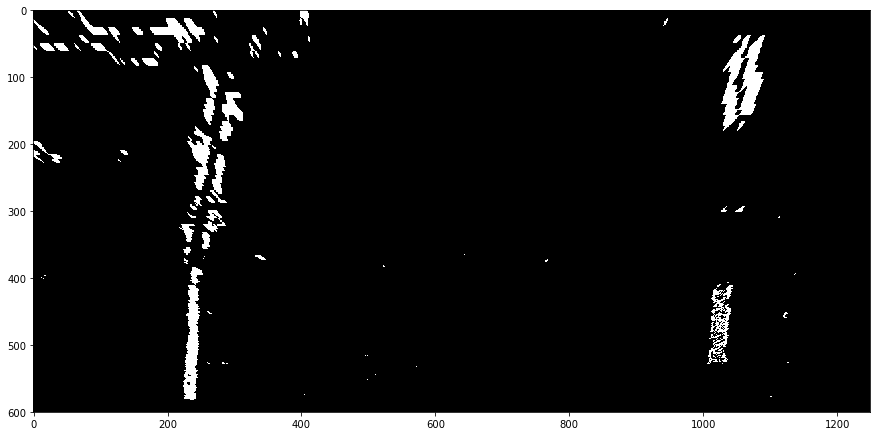

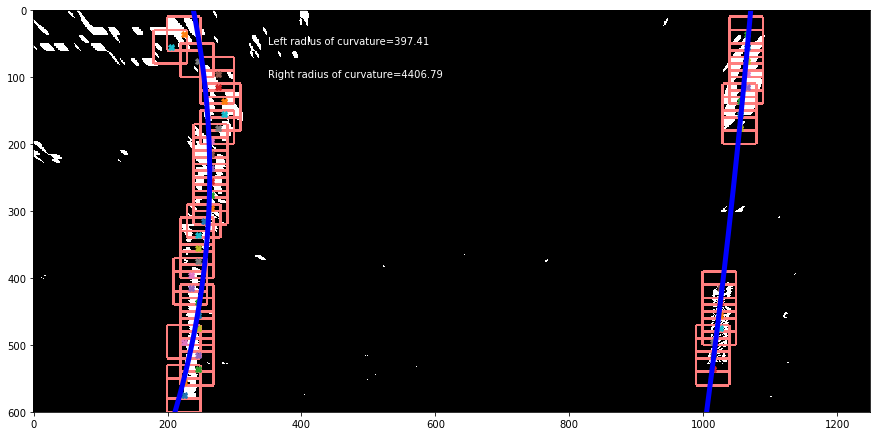

In [126]:
left = Line()
right = Line()
left, right = find_lanes(warped, left, right)

### Step 5.5: Function to draw lines etc on the image, code was taken from the Tips and Tricks section

In [160]:
def draw_lane(warped, undist, left, right):
    warp_clean = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_clean, warp_clean, warp_clean))

    # Recast the x and y points for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left.currfit_x, left.currfit_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.currfit_x, right.currfit_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Transform the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, img_inv, (warped.shape[1], warped.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'roc: left={:.2f} right={:.2f}'.format(left.radius_of_curvature,right.radius_of_curvature),(320,70), font,1 ,(255,255,255))
    cv2.putText(result,'off-centre: {:.2f}m'.format(left.line_base_pos),(420,120), font, 1,(255,255,255))

    if PLOT_IMGS:
        _, ax = plt.subplots(1,1, figsize=(15,10))
        ax.set_title("output")
        ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB) )
        plt.show()
    return result

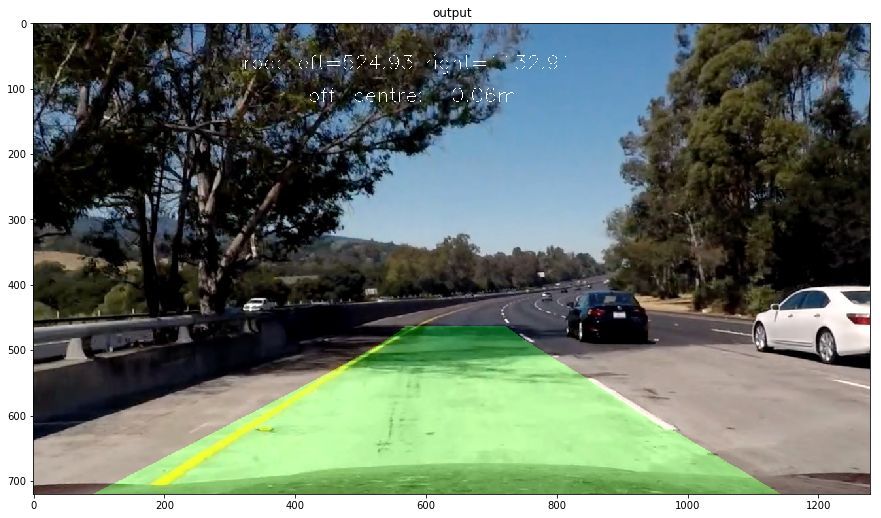

In [117]:
_ = draw_lane(warped, undist, left, right)

In [161]:
def process_video(img):
    global left
    global right
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary_s = chan_thresholds(undist)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)    
    sobel_combo = calc_sobel(gray)
    combo = combine_gradient(gray, sobel_combo, binary_s)
    warped = warp_perspective(combo, persp)
    _ = warp_perspective(warped, persp_inv)
    left, right = find_lanes(warped, left, right)
    result = draw_lane(warped, undist, left, right)
    return result

In [162]:
from moviepy.editor import VideoFileClip
left = Line()
right = Line()
PLOT_IMGS = False
output = 'output_video.mp4'
clip_in = VideoFileClip("../project_video.mp4")
clip_out = clip_in.fl_image(process_video)
%time clip_out.write_videofile(output, audio=False, write_logfile=True, verbose=False)







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<07:36,  2.76it/s]




  0%|          | 2/1261 [00:00<07:35,  2.77it/s]




  0%|          | 3/1261 [00:01<07:39,  2.74it/s]








  0%|          | 4/1261 [00:01<07:30,  2.79it/s]




  0%|          | 5/1261 [00:01<07:20,  2.85it/s]




  0%|          | 6/1261 [00:02<07:12,  2.90it/s]




  1%|          | 7/1261 [00:02<07:06,  2.94it/s]




  1%|          | 8/1261 [00:02<07:04,  2.95it/s]




  1%|          | 9/1261 [00:03<07:03,  2.96it/s]




  1%|          | 10/1261 [00:03<07:03,  2.96it/s]




  1%|          | 11/1261 [00:03<07:01,  2.97it/s]




  1%|          | 12/1261 [00:04<06:59,  2.98it/s]




  1%|          | 13/1261 [00:04<07:00,  2.97it/s]




  1%|          | 14/1261 [00:04<07:02,  2.95it/s]




  1%|          | 15/1261 [00:05<07:04,  2.93it/s]




  1%|▏         | 16/1261 [00:05<07:02,  2.95it/s]




  1%|▏         | 17/1261 [00:05<07:10,  2.89it/s]




  1%|▏         | 18/1261 [00:06<07:15

  9%|▉         | 118/1261 [00:40<06:22,  2.99it/s]




  9%|▉         | 119/1261 [00:40<06:22,  2.99it/s]




 10%|▉         | 120/1261 [00:41<06:25,  2.96it/s]




 10%|▉         | 121/1261 [00:41<06:26,  2.95it/s]




 10%|▉         | 122/1261 [00:41<06:22,  2.98it/s]




 10%|▉         | 123/1261 [00:42<06:22,  2.97it/s]




 10%|▉         | 124/1261 [00:42<06:18,  3.00it/s]




 10%|▉         | 125/1261 [00:42<06:20,  2.99it/s]




 10%|▉         | 126/1261 [00:43<06:18,  3.00it/s]




 10%|█         | 127/1261 [00:43<06:20,  2.98it/s]




 10%|█         | 128/1261 [00:43<06:16,  3.01it/s]




 10%|█         | 129/1261 [00:44<06:17,  3.00it/s]




 10%|█         | 130/1261 [00:44<06:15,  3.01it/s]




 10%|█         | 131/1261 [00:44<06:16,  3.00it/s]




 10%|█         | 132/1261 [00:45<06:17,  2.99it/s]




 11%|█         | 133/1261 [00:45<06:18,  2.98it/s]




 11%|█         | 134/1261 [00:45<06:17,  2.99it/s]




 11%|█         | 135/1261 [00:46<06:18,  2.97it/s]




 11%|█    

 19%|█▊        | 235/1261 [01:19<05:48,  2.94it/s]




 19%|█▊        | 236/1261 [01:20<05:45,  2.97it/s]




 19%|█▉        | 237/1261 [01:20<05:44,  2.97it/s]




 19%|█▉        | 238/1261 [01:20<05:42,  2.98it/s]




 19%|█▉        | 239/1261 [01:21<05:44,  2.96it/s]




 19%|█▉        | 240/1261 [01:21<05:46,  2.95it/s]




 19%|█▉        | 241/1261 [01:22<05:52,  2.89it/s]




 19%|█▉        | 242/1261 [01:22<05:53,  2.88it/s]




 19%|█▉        | 243/1261 [01:22<05:46,  2.94it/s]




 19%|█▉        | 244/1261 [01:23<05:47,  2.93it/s]




 19%|█▉        | 245/1261 [01:23<05:42,  2.96it/s]




 20%|█▉        | 246/1261 [01:23<05:42,  2.96it/s]




 20%|█▉        | 247/1261 [01:24<05:41,  2.97it/s]




 20%|█▉        | 248/1261 [01:24<05:42,  2.96it/s]




 20%|█▉        | 249/1261 [01:24<05:39,  2.98it/s]




 20%|█▉        | 250/1261 [01:25<05:40,  2.97it/s]




 20%|█▉        | 251/1261 [01:25<05:37,  2.99it/s]




 20%|█▉        | 252/1261 [01:25<05:39,  2.97it/s]




 20%|██   

 28%|██▊       | 352/1261 [01:59<05:02,  3.00it/s]




 28%|██▊       | 353/1261 [01:59<05:03,  3.00it/s]




 28%|██▊       | 354/1261 [02:00<05:04,  2.97it/s]




 28%|██▊       | 355/1261 [02:00<05:04,  2.98it/s]




 28%|██▊       | 356/1261 [02:00<05:06,  2.95it/s]




 28%|██▊       | 357/1261 [02:01<05:04,  2.97it/s]




 28%|██▊       | 358/1261 [02:01<05:05,  2.95it/s]




 28%|██▊       | 359/1261 [02:01<05:02,  2.98it/s]




 29%|██▊       | 360/1261 [02:02<05:03,  2.97it/s]




 29%|██▊       | 361/1261 [02:02<05:04,  2.95it/s]




 29%|██▊       | 362/1261 [02:02<05:07,  2.92it/s]




 29%|██▉       | 363/1261 [02:03<05:13,  2.87it/s]




 29%|██▉       | 364/1261 [02:03<05:07,  2.91it/s]




 29%|██▉       | 365/1261 [02:03<05:08,  2.90it/s]




 29%|██▉       | 366/1261 [02:04<05:05,  2.93it/s]




 29%|██▉       | 367/1261 [02:04<05:05,  2.92it/s]




 29%|██▉       | 368/1261 [02:04<05:03,  2.94it/s]




 29%|██▉       | 369/1261 [02:05<05:02,  2.95it/s]




 29%|██▉  

 37%|███▋      | 469/1261 [02:39<04:25,  2.99it/s]




 37%|███▋      | 470/1261 [02:39<04:24,  2.99it/s]




 37%|███▋      | 471/1261 [02:39<04:25,  2.98it/s]




 37%|███▋      | 472/1261 [02:40<04:25,  2.97it/s]




 38%|███▊      | 473/1261 [02:40<04:26,  2.96it/s]




 38%|███▊      | 474/1261 [02:40<04:27,  2.95it/s]




 38%|███▊      | 475/1261 [02:41<04:26,  2.95it/s]




 38%|███▊      | 476/1261 [02:41<04:26,  2.95it/s]




 38%|███▊      | 477/1261 [02:41<04:23,  2.97it/s]




 38%|███▊      | 478/1261 [02:42<04:25,  2.95it/s]




 38%|███▊      | 479/1261 [02:42<04:26,  2.93it/s]




 38%|███▊      | 480/1261 [02:42<04:29,  2.90it/s]




 38%|███▊      | 481/1261 [02:43<04:25,  2.93it/s]




 38%|███▊      | 482/1261 [02:43<04:24,  2.95it/s]




 38%|███▊      | 483/1261 [02:43<04:21,  2.97it/s]




 38%|███▊      | 484/1261 [02:44<04:21,  2.98it/s]




 38%|███▊      | 485/1261 [02:44<04:19,  2.99it/s]




 39%|███▊      | 486/1261 [02:44<04:21,  2.97it/s]




 39%|███▊ 

 46%|████▋     | 586/1261 [03:19<03:47,  2.96it/s]




 47%|████▋     | 587/1261 [03:19<03:46,  2.97it/s]




 47%|████▋     | 588/1261 [03:19<03:46,  2.97it/s]




 47%|████▋     | 589/1261 [03:20<03:46,  2.97it/s]




 47%|████▋     | 590/1261 [03:20<03:48,  2.94it/s]




 47%|████▋     | 591/1261 [03:20<03:48,  2.93it/s]




 47%|████▋     | 592/1261 [03:21<03:48,  2.93it/s]




 47%|████▋     | 593/1261 [03:21<03:45,  2.96it/s]




 47%|████▋     | 594/1261 [03:21<03:45,  2.96it/s]




 47%|████▋     | 595/1261 [03:22<03:43,  2.98it/s]




 47%|████▋     | 596/1261 [03:22<03:43,  2.98it/s]




 47%|████▋     | 597/1261 [03:22<03:41,  2.99it/s]




 47%|████▋     | 598/1261 [03:23<03:43,  2.97it/s]




 48%|████▊     | 599/1261 [03:23<03:42,  2.97it/s]




 48%|████▊     | 600/1261 [03:23<03:46,  2.92it/s]




 48%|████▊     | 601/1261 [03:24<03:43,  2.95it/s]




 48%|████▊     | 602/1261 [03:24<03:44,  2.94it/s]




 48%|████▊     | 603/1261 [03:24<03:44,  2.93it/s]




 48%|████▊

 56%|█████▌    | 703/1261 [03:58<03:07,  2.98it/s]




 56%|█████▌    | 704/1261 [03:59<03:10,  2.93it/s]




 56%|█████▌    | 705/1261 [03:59<03:09,  2.93it/s]




 56%|█████▌    | 706/1261 [03:59<03:07,  2.96it/s]




 56%|█████▌    | 707/1261 [04:00<03:07,  2.95it/s]




 56%|█████▌    | 708/1261 [04:00<03:05,  2.98it/s]




 56%|█████▌    | 709/1261 [04:00<03:05,  2.97it/s]




 56%|█████▋    | 710/1261 [04:01<03:04,  2.98it/s]




 56%|█████▋    | 711/1261 [04:01<03:05,  2.96it/s]




 56%|█████▋    | 712/1261 [04:01<03:04,  2.98it/s]




 57%|█████▋    | 713/1261 [04:02<03:04,  2.96it/s]




 57%|█████▋    | 714/1261 [04:02<03:02,  2.99it/s]




 57%|█████▋    | 715/1261 [04:02<03:03,  2.98it/s]




 57%|█████▋    | 716/1261 [04:03<03:02,  2.98it/s]




 57%|█████▋    | 717/1261 [04:03<03:04,  2.94it/s]




 57%|█████▋    | 718/1261 [04:03<03:02,  2.97it/s]




 57%|█████▋    | 719/1261 [04:04<03:03,  2.96it/s]




 57%|█████▋    | 720/1261 [04:04<03:02,  2.97it/s]




 57%|█████

 65%|██████▌   | 820/1261 [04:38<02:29,  2.95it/s]




 65%|██████▌   | 821/1261 [04:38<02:27,  2.98it/s]




 65%|██████▌   | 822/1261 [04:38<02:28,  2.97it/s]




 65%|██████▌   | 823/1261 [04:39<02:26,  2.99it/s]




 65%|██████▌   | 824/1261 [04:39<02:26,  2.98it/s]




 65%|██████▌   | 825/1261 [04:39<02:26,  2.98it/s]




 66%|██████▌   | 826/1261 [04:40<02:27,  2.96it/s]




 66%|██████▌   | 827/1261 [04:40<02:26,  2.96it/s]




 66%|██████▌   | 828/1261 [04:40<02:26,  2.96it/s]




 66%|██████▌   | 829/1261 [04:41<02:24,  2.99it/s]




 66%|██████▌   | 830/1261 [04:41<02:24,  2.98it/s]




 66%|██████▌   | 831/1261 [04:41<02:22,  3.01it/s]




 66%|██████▌   | 832/1261 [04:42<02:23,  2.99it/s]




 66%|██████▌   | 833/1261 [04:42<02:21,  3.02it/s]




 66%|██████▌   | 834/1261 [04:42<02:22,  2.99it/s]




 66%|██████▌   | 835/1261 [04:43<02:21,  3.01it/s]




 66%|██████▋   | 836/1261 [04:43<02:21,  3.00it/s]




 66%|██████▋   | 837/1261 [04:43<02:21,  3.00it/s]




 66%|█████

 74%|███████▍  | 937/1261 [05:17<01:50,  2.92it/s]




 74%|███████▍  | 938/1261 [05:18<01:49,  2.95it/s]




 74%|███████▍  | 939/1261 [05:18<01:51,  2.90it/s]




 75%|███████▍  | 940/1261 [05:18<01:49,  2.93it/s]




 75%|███████▍  | 941/1261 [05:19<01:48,  2.94it/s]




 75%|███████▍  | 942/1261 [05:19<01:47,  2.96it/s]




 75%|███████▍  | 943/1261 [05:20<01:48,  2.94it/s]




 75%|███████▍  | 944/1261 [05:20<01:48,  2.92it/s]




 75%|███████▍  | 945/1261 [05:20<01:47,  2.94it/s]




 75%|███████▌  | 946/1261 [05:21<01:48,  2.90it/s]




 75%|███████▌  | 947/1261 [05:21<01:47,  2.93it/s]




 75%|███████▌  | 948/1261 [05:21<01:47,  2.90it/s]




 75%|███████▌  | 949/1261 [05:22<01:45,  2.95it/s]




 75%|███████▌  | 950/1261 [05:22<01:46,  2.92it/s]




 75%|███████▌  | 951/1261 [05:22<01:47,  2.90it/s]




 75%|███████▌  | 952/1261 [05:23<01:47,  2.87it/s]




 76%|███████▌  | 953/1261 [05:23<01:45,  2.92it/s]




 76%|███████▌  | 954/1261 [05:23<01:44,  2.93it/s]




 76%|█████

 84%|████████▎ | 1053/1261 [05:57<01:10,  2.96it/s]




 84%|████████▎ | 1054/1261 [05:57<01:10,  2.96it/s]




 84%|████████▎ | 1055/1261 [05:58<01:09,  2.96it/s]




 84%|████████▎ | 1056/1261 [05:58<01:09,  2.97it/s]




 84%|████████▍ | 1057/1261 [05:59<01:09,  2.94it/s]




 84%|████████▍ | 1058/1261 [05:59<01:09,  2.92it/s]




 84%|████████▍ | 1059/1261 [05:59<01:08,  2.95it/s]




 84%|████████▍ | 1060/1261 [06:00<01:08,  2.95it/s]




 84%|████████▍ | 1061/1261 [06:00<01:07,  2.97it/s]




 84%|████████▍ | 1062/1261 [06:00<01:07,  2.96it/s]




 84%|████████▍ | 1063/1261 [06:01<01:06,  2.96it/s]




 84%|████████▍ | 1064/1261 [06:01<01:06,  2.94it/s]




 84%|████████▍ | 1065/1261 [06:01<01:05,  2.97it/s]




 85%|████████▍ | 1066/1261 [06:02<01:05,  2.96it/s]




 85%|████████▍ | 1067/1261 [06:02<01:05,  2.98it/s]




 85%|████████▍ | 1068/1261 [06:02<01:05,  2.97it/s]




 85%|████████▍ | 1069/1261 [06:03<01:05,  2.95it/s]




 85%|████████▍ | 1070/1261 [06:03<01:06,  2.89it

 93%|█████████▎| 1168/1261 [06:37<00:33,  2.79it/s]




 93%|█████████▎| 1169/1261 [06:37<00:32,  2.86it/s]




 93%|█████████▎| 1170/1261 [06:37<00:32,  2.80it/s]




 93%|█████████▎| 1171/1261 [06:38<00:32,  2.76it/s]




 93%|█████████▎| 1172/1261 [06:38<00:32,  2.74it/s]




 93%|█████████▎| 1173/1261 [06:39<00:31,  2.76it/s]




 93%|█████████▎| 1174/1261 [06:39<00:31,  2.80it/s]




 93%|█████████▎| 1175/1261 [06:39<00:31,  2.74it/s]




 93%|█████████▎| 1176/1261 [06:40<00:30,  2.76it/s]




 93%|█████████▎| 1177/1261 [06:40<00:30,  2.76it/s]




 93%|█████████▎| 1178/1261 [06:40<00:30,  2.74it/s]




 93%|█████████▎| 1179/1261 [06:41<00:30,  2.72it/s]




 94%|█████████▎| 1180/1261 [06:41<00:29,  2.77it/s]




 94%|█████████▎| 1181/1261 [06:41<00:29,  2.75it/s]




 94%|█████████▎| 1182/1261 [06:42<00:29,  2.72it/s]




 94%|█████████▍| 1183/1261 [06:42<00:28,  2.71it/s]




 94%|█████████▍| 1184/1261 [06:43<00:28,  2.66it/s]




 94%|█████████▍| 1185/1261 [06:43<00:28,  2.71it

CPU times: user 10min 51s, sys: 26.2 s, total: 11min 18s
Wall time: 7min 11s
